In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils
from wiki.newphet import load_prophet_prop
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output
import gc

In [3]:
def load_plot(page, plot_y_org=True):
    forecast = pd.read_feather(PROPHET_PATH+VERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()
    forecast = pd.read_feather(PROPHET_PATH+YVERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [4]:
PROPHET_PATH = '../data/prophet/'
CACHE_PATH = 'cache/'
RESULTS_PATH = 'results/'
VERSION ='v7t/'
YVERSION ='v7ty/'

In [5]:
mediandf = pd.read_feather('../data/median_for_120_60.f') 

In [6]:
mediandf.page_index = mediandf.page_index.astype(int)
mediandf = mediandf.sort_values(by='page_index').reset_index().drop('index', axis=1)
print(mediandf.iloc[:,2:].mean())
print(mediandf.info())
mediandf.head()

median_pred_60               945.877619
median_pred_120             1079.880355
prevYear_median_pred_60     1088.881776
prevYear_median_pred_120    1088.969089
smape_60_to_0                 41.043204
smape_120_to_60               40.059153
prevYear_smape_60_to_0        50.551424
prevYear_smape_120_to_60      47.544453
nans_start_to_120             45.414792
nans_120_to_60                 1.424264
nans_60_to_0                   1.536367
prevYear_nans_60_to_0          2.868712
prevYear_nans_120_to_60        3.540000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 15 columns):
page_index                  145063 non-null int64
Page                        145063 non-null object
median_pred_60              145063 non-null int64
median_pred_120             145063 non-null int64
prevYear_median_pred_60     145063 non-null int64
prevYear_median_pred_120    145063 non-null int64
smape_60_to_0               144151 non-null float64
s

,page_index,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,smape_60_to_0,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60
0,0,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,32.278432,25.959053,40.870388,32.116348,0,0,0,0,0
1,1,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,42.847863,34.415304,60.431899,32.054860,0,0,0,0,0
2,2,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,64.305367,65.870407,47.163640,56.748585,0,0,0,0,0
3,3,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,32.250349,33.896551,35.401843,49.278494,0,0,0,0,0
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,48.547274,38.718059,54.426324,57.220372,291,0,0,0,0


In [7]:
test_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f'); 
test_df.page_index = test_df.page_index.astype(int)
print(test_df[VERSION[:-1]+'_train'].mean())
test_df = test_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#test_df = test_df.drop(VERSION[:-1]+'_train', axis=1)
print(test_df.shape)
print(test_df.info())
print(test_df[VERSION[:-1]+'_val'].mean())
test_df.head()

66.9608163262
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7t_train     145063 non-null float64
v7t_val       144151 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
99.0350088156


,page_index,v7t_train,v7t_val
0,0,46.736751,32.642601
1,1,48.666767,83.565553
2,2,69.758611,120.451293
3,3,45.255355,38.493515
4,4,66.002965,89.498846


In [8]:
Ytest_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+YVERSION[:-1]+'df.f'); 
Ytest_df.page_index = Ytest_df.page_index.astype(int)
print(Ytest_df[YVERSION[:-1]+'_train'].mean())
Ytest_df = Ytest_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#Ytest_df = Ytest_df.drop(VERSION[:-1]+'_train', axis=1)
print(Ytest_df.shape)
print(Ytest_df.info())
print(Ytest_df[YVERSION[:-1]+'_val'].mean())
Ytest_df.head()

64.5948646161
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7ty_train    145059 non-null float64
v7ty_val      141348 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
84.8706792497


,page_index,v7ty_train,v7ty_val
0,0,47.323987,44.956479
1,1,48.262866,61.287282
2,2,71.127792,58.073251
3,3,46.191346,52.285567
4,4,62.962499,132.877882


In [9]:
df = Ytest_df.merge(test_df, on='page_index'); print(df.shape)
df = df.merge(mediandf, on='page_index'); print(df.shape)
df['Ytest_gain'] = df.prevYear_smape_60_to_0 - df[YVERSION[:-1]+'_val']
df['test_gain'] = df.smape_60_to_0 - df[VERSION[:-1]+'_val']; df.head()

(145063, 5)
(145063, 19)


,page_index,v7ty_train,v7ty_val,v7t_train,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,...,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,Ytest_gain,test_gain
0,0,47.323987,44.956479,46.736751,32.642601,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,...,25.959053,40.870388,32.116348,0,0,0,0,0,-4.086092,-0.364169
1,1,48.262866,61.287282,48.666767,83.565553,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,...,34.415304,60.431899,32.054860,0,0,0,0,0,-0.855383,-40.717689
2,2,71.127792,58.073251,69.758611,120.451293,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,...,65.870407,47.163640,56.748585,0,0,0,0,0,-10.909611,-56.145926
3,3,46.191346,52.285567,45.255355,38.493515,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,...,33.896551,35.401843,49.278494,0,0,0,0,0,-16.883725,-6.243166
4,4,62.962499,132.877882,66.002965,89.498846,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,...,38.718059,54.426324,57.220372,291,0,0,0,0,-78.451559,-40.951572


In [10]:
del Ytest_df
del test_df
del mediandf
gc.collect()

758

In [11]:
median_rolling_smape =  wiki.val.load_test_median_rolling_smape()

median_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.smape_60_to_0.fillna(-1) == median_rolling_smape.iloc[:,-60].fillna(-1)).sum() -> 145063


In [12]:
print(median_rolling_smape.iloc[[0],[0,-1]])
print(median_rolling_smape.shape)
median_rolling_smape.head()

   2015-07-01  2017-08-31
0         NaN         NaN
(145063, 793)


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,NaN,59.292576,47.521198,42.279365,43.644768,45.184539,43.202023,41.268254,42.592001,44.607579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,73.260387,69.616005,67.684029,68.770630,69.095268,70.576750,71.639287,71.655954,74.052468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,99.293651,180.000000,99.626984,101.293651,100.341270,100.722222,99.388889,99.388889,99.055556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,88.967936,70.416485,56.959173,69.960825,55.197029,60.669316,53.567910,52.966730,54.192555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
yhat_rolling_smape =  wiki.val.load_prophet_rolling_smape(VERSION, test_version=True)

prophet_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
(df.v7t_val.round(decimals=6).fillna(-10) == yhat_rolling_smape.iloc[:,-60].round(decimals=6).fillna(-10)).sum() -> 145063


In [14]:
print(yhat_rolling_smape.iloc[[0],[0,-1]])
print(yhat_rolling_smape.shape)
yhat_rolling_smape.head()

   2015-08-30  2017-08-31
0      46.014         NaN
(145063, 733)


,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,46.01400,45.40289,45.30144,44.52684,45.14765,45.53654,46.25179,46.21211,46.71445,45.58791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53.50449,53.26103,53.13358,52.39626,52.15095,51.44100,50.79423,51.01956,52.92075,53.88034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.58922,71.25588,72.57456,72.46874,72.02430,72.02430,71.74652,72.80472,72.63806,72.16187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,53.84082,54.01158,53.71279,52.48091,52.18176,52.27033,52.99497,52.96078,53.43351,53.60186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


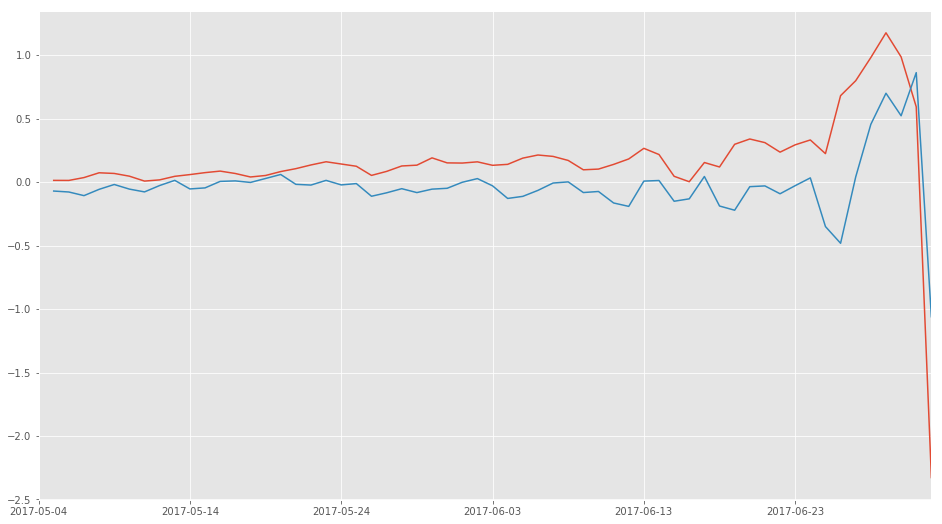

In [15]:
yhat_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()
median_rolling_smape.iloc[:,-120:-60].diff(1, axis=1).mean(axis=0).plot()

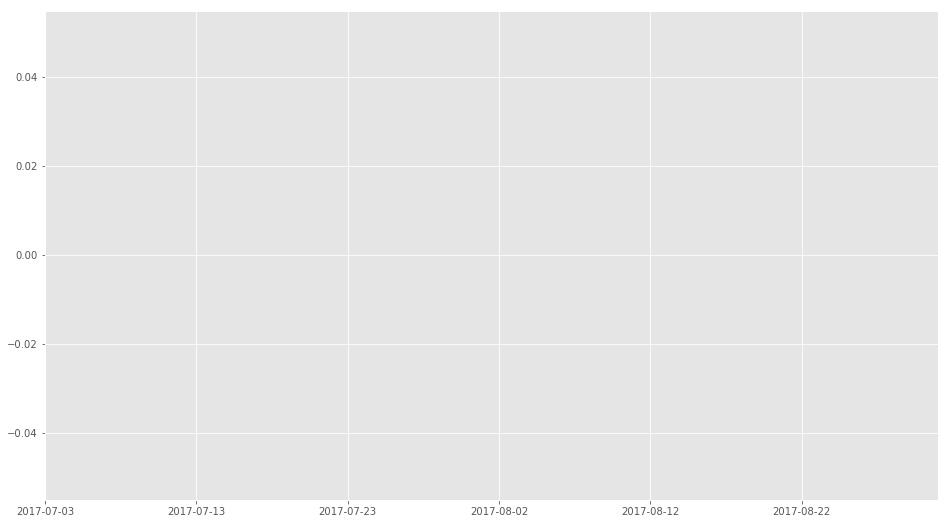

In [16]:
yhat_rolling_smape.iloc[:,-60:].diff(1, axis=1).mean(axis=0).plot()
median_rolling_smape.iloc[:,-60:].diff(1, axis=1).mean(axis=0).plot()

In [17]:
cut_off = None
df['rolling_gain_mean'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape.iloc[:,:cut_off]).mean(axis=1)
df['rolling_gain_std'] = (median_rolling_smape.iloc[:,:cut_off] - yhat_rolling_smape.iloc[:,:cut_off]).std(axis=1)

In [18]:
print(df['rolling_gain_mean'].max(), df['rolling_gain_mean'].min())
print(df['rolling_gain_std'].max(), df['rolling_gain_std'].min())

200.0 -193.587283558
172.734306215 0.0


In [19]:
df.head()

,page_index,v7ty_train,v7ty_val,v7t_train,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,...,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,Ytest_gain,test_gain,rolling_gain_mean,rolling_gain_std
0,0,47.323987,44.956479,46.736751,32.642601,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,...,32.116348,0,0,0,0,0,-4.086092,-0.364169,-4.586877,7.105016
1,1,48.262866,61.287282,48.666767,83.565553,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,...,32.054860,0,0,0,0,0,-0.855383,-40.717689,-5.471587,6.573979
2,2,71.127792,58.073251,69.758611,120.451293,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,...,56.748585,0,0,0,0,0,-10.909611,-56.145926,-11.048583,13.843225
3,3,46.191346,52.285567,45.255355,38.493515,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,...,49.278494,0,0,0,0,0,-16.883725,-6.243166,-2.399449,6.971026
4,4,62.962499,132.877882,66.002965,89.498846,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,...,57.220372,291,0,0,0,0,-78.451559,-40.951572,11.684981,33.645347


In [20]:
df[['test_gain','rolling_gain_mean','rolling_gain_std']].corr()

,test_gain,rolling_gain_mean,rolling_gain_std
test_gain,1.000000,0.568253,-0.565914
rolling_gain_mean,0.568253,1.000000,-0.321331
rolling_gain_std,-0.565914,-0.321331,1.000000


# Feature Testing Area

In [38]:
yhat = wiki.newphet.load_prophet_prop(VERSION, 'yhat')
#trend = wiki.newphet.load_prophet_prop(VERSION, 'trend')
y_df = wiki.newphet.load_prophet_prop(VERSION, 'y')
Yyhat = wiki.newphet.load_prophet_prop(YVERSION, 'yhat')

IndexingError: [Index(['2017-07-03', '2017-07-04', '2017-07-05', '2017-07-06', '2017-07-07',
       '2017-07-08', '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
       '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16', '2017-07-17',
       '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21', '2017-07-22',
       '2017-07-23', '2017-07-24', '2017-07-25', '2017-07-26', '2017-07-27',
       '2017-07-28', '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
       '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
       '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11',
       '2017-08-12', '2017-08-13', '2017-08-14', '2017-08-15', '2017-08-16',
       '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
       '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
       '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object')]

In [41]:
Yyhat[yhat.columns[-60:]] = yhat.iloc[:,-60:]

In [42]:
yhat.columns[-60:]

Index(['2017-07-03', '2017-07-04', '2017-07-05', '2017-07-06', '2017-07-07',
       '2017-07-08', '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
       '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16', '2017-07-17',
       '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21', '2017-07-22',
       '2017-07-23', '2017-07-24', '2017-07-25', '2017-07-26', '2017-07-27',
       '2017-07-28', '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
       '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
       '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11',
       '2017-08-12', '2017-08-13', '2017-08-14', '2017-08-15', '2017-08-16',
       '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
       '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26',
       '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype='object')

In [43]:
Yyhat.shape

(145063, 793)

In [44]:
Yyhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,19.0,15.0,16.0,15.0,14.0,10.0,13.0,12.0,8.0,10.0,...,23.0,23.0,20.0,23.0,23.0,23.0,21.0,24.0,24.0,21.0
1,22.0,21.0,24.0,31.0,24.0,25.0,31.0,30.0,27.0,28.0,...,61.0,57.0,54.0,56.0,60.0,53.0,51.0,57.0,52.0,49.0
2,3.0,1.0,0.0,2.0,2.0,1.0,0.0,3.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,1.0
3,23.0,21.0,23.0,23.0,21.0,25.0,24.0,23.0,22.0,23.0,...,12.0,12.0,10.0,11.0,12.0,9.0,12.0,10.0,10.0,8.0
4,3.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,5.0,4.0,7.0,8.0,6.0,3.0,8.0,10.0


In [37]:
yhat.iloc[:,-60:]

,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,3.773585,42.105263,60.000000,50.000000,14.634146,18.867925,4.444444,12.765957,0.000000,19.047619,...,55.172414,82.926829,4.081633,4.444444,4.081633,61.111111,58.823529,16.666667,4.081633,13.333333
1,79.245283,46.666667,79.365079,87.719298,181.754386,70.967742,47.154472,50.000000,86.792453,114.285714,...,103.448276,40.000000,96.774194,34.666667,27.848101,39.024390,27.027027,31.884058,27.848101,46.153846
2,54.545455,100.000000,100.000000,133.333333,107.692308,66.666667,66.666667,40.000000,22.222222,100.000000,...,40.000000,140.740741,58.823529,66.666667,40.000000,73.684211,66.666667,46.153846,82.352941,25.000000
3,35.897436,85.714286,34.146341,42.105263,4.651163,114.285714,117.241379,15.384615,62.857143,31.578947,...,0.000000,75.409836,19.047619,0.000000,48.275862,15.384615,22.222222,5.128205,146.456693,12.500000
4,40.000000,104.761905,178.947368,82.352941,80.000000,93.333333,90.909091,85.714286,100.000000,200.000000,...,200.000000,200.000000,170.370370,152.000000,163.636364,142.857143,131.428571,147.826087,177.777778,120.000000
5,41.666667,75.000000,50.000000,58.823529,15.384615,137.777778,23.529412,19.047619,13.333333,88.888889,...,66.666667,111.864407,81.818182,57.777778,69.565217,54.545455,21.052632,11.764706,60.869565,14.285714
6,186.666667,66.666667,100.000000,150.000000,18.181818,66.666667,146.666667,100.000000,200.000000,62.068966,...,97.142857,102.222222,96.774194,62.295082,104.000000,60.000000,84.210526,114.285714,71.428571,92.307692
7,6.315789,34.146341,51.851852,106.250000,108.571429,58.823529,131.034483,123.595506,125.274725,145.454545,...,48.226950,21.276596,100.775194,88.721805,3.883495,63.157895,25.454545,111.504425,2.352941,34.920635
8,29.411765,60.377358,12.500000,24.561404,3.076923,25.352113,69.090909,48.979592,50.000000,9.523810,...,5.882353,66.666667,21.538462,13.333333,10.526316,24.657534,6.250000,9.836066,80.412371,35.294118
9,38.596491,22.222222,40.000000,32.000000,23.076923,29.787234,17.391304,18.181818,51.282051,27.450980,...,24.561404,75.324675,32.258065,11.320755,46.153846,12.765957,35.294118,0.000000,36.065574,7.407407


yhat_org = wiki.newphet.load_prophet_prop(VERSION, 'yhat_org')
df['yhat_org_mean'] = yhat_org.iloc[:,-60:].mean(axis=1)
df['yhat_median'] = yhat.iloc[:,-60:].median(axis=1)

In [26]:
y_df = y_df.shift(365, axis=1)
yhat = yhat.shift(365, axis=1)
Yyhat = Yyhat.shift(365, axis=1)

In [27]:
Yyhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,31.0,31.0,29.0,26.0,27.0,26.0,22.0,22.0,22.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,22.0,30.0,24.0,25.0,33.0,33.0,31.0,35.0,42.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,5.0,6.0,6.0,5.0,4.0,6.0,3.0,3.0,4.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.0,28.0,28.0,26.0,29.0,28.0,28.0,26.0,27.0,27.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,7.0,9.0,10.0,6.0,2.0,6.0,7.0,4.0,6.0


In [28]:
train = pd.read_feather('../data/train.f')

In [29]:
y_df = wiki.val.get_smape_df(train,y_df)
yhat = wiki.val.get_smape_df(train,yhat)
Yyhat = wiki.val.get_smape_df(train,Yyhat)

AssertionError: 

In [32]:
yhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.172414,82.926829,4.081633,4.444444,4.081633,61.111111,58.823529,16.666667,4.081633,13.333333
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.448276,40.000000,96.774194,34.666667,27.848101,39.024390,27.027027,31.884058,27.848101,46.153846
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.000000,140.740741,58.823529,66.666667,40.000000,73.684211,66.666667,46.153846,82.352941,25.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,75.409836,19.047619,0.000000,48.275862,15.384615,22.222222,5.128205,146.456693,12.500000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.000000,200.000000,170.370370,152.000000,163.636364,142.857143,131.428571,147.826087,177.777778,120.000000


In [33]:
Yyhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,31.0,31.0,29.0,26.0,27.0,26.0,22.0,22.0,22.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,22.0,30.0,24.0,25.0,33.0,33.0,31.0,35.0,42.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,5.0,6.0,6.0,5.0,4.0,6.0,3.0,3.0,4.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.0,28.0,28.0,26.0,29.0,28.0,28.0,26.0,27.0,27.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,7.0,9.0,10.0,6.0,2.0,6.0,7.0,4.0,6.0


In [ ]:
Yyhat.head()

In [ ]:
df['shift_y_smape'] = y_df.iloc[:,-60:].mean(axis=1)
df['shift_yhat_smape'] = yhat.iloc[:,-60:].mean(axis=1)
df['shift_Yyhat_smape'] = Yyhat.iloc[:,-60:].mean(axis=1)
del y_df
del yhat
del Yyhat
gc.collect()

In [ ]:
df['shift_y_gain'] = df.smape_60_to_0 - df['shift_y_smape']
df['shift_yhat_gain'] = df.smape_60_to_0 - df['shift_yhat_smape']
df['shift_Yyhat_gain'] = df.smape_60_to_0 - df['shift_Yyhat_smape']

# Filter Testing

In [ ]:
#BASE_SCORE = df.smape_60_to_0.mean()

In [ ]:
BASE_SCORE

In [ ]:
filter_df = ((df['rolling_gain_std'] < df['rolling_gain_mean']) &
            (df['Ytest_gain'] > 0)
             )
print(len(df[filter_df]))

In [ ]:
pd.concat([df[filter_df].v7t_val,
           df[~filter_df].smape_60_to_0]).mean()

In [ ]:
pd.concat([df[filter_df].shift_y_smape,
           df[~filter_df].smape_60_to_0]).mean()

In [ ]:
pd.concat([df[filter_df].shift_Yyhat_smape,
           df[~filter_df].smape_60_to_0]).mean()

In [ ]:
pd.concat([df[filter_df].shift_yhat_smape,
           df[~filter_df].smape_60_to_0]).mean()

In [ ]:
filter_df2 = ((df['rolling_gain_mean'] - df['rolling_gain_std'] + df['Ytest_gain']) > )
print(len(df[filter_df2]))

In [ ]:
pd.concat([df[filter_df2].v7t_val,
           df[~filter_df2].smape_60_to_0]).mean()

In [ ]:
pd.concat([df[filter_df2].shift_y_smape,
           df[~filter_df2].smape_60_to_0]).mean()

In [ ]:
pd.concat([df[filter_df2].shift_Yyhat_smape,
           df[~filter_df2].smape_60_to_0]).mean()

In [ ]:
pd.concat([df[filter_df2].shift_yhat_smape,
           df[~filter_df2].smape_60_to_0]).mean()

In [ ]:
df['magic_gain'] = (df['rolling_gain_mean'] - df['rolling_gain_std'] + df['Ytest_gain'])

In [ ]:
filter_df3 = ((df['rolling_gain_mean'] - df['rolling_gain_std'] + df['Ytest_gain']) > 10)
print(len(df[filter_df3]))

In [ ]:
pd.concat([df[filter_df3].v7t_val,
           df[~filter_df3].smape_60_to_0]).mean()

In [ ]:
pd.concat([df[filter_df3].shift_y_smape,
           df[~filter_df3].smape_60_to_0]).mean()

In [ ]:
pd.concat([df[filter_df3].shift_Yyhat_smape,
           df[~filter_df3].smape_60_to_0]).mean()

In [ ]:
pd.concat([df[filter_df3].shift_yhat_smape,
           df[~filter_df3].smape_60_to_0]).mean()

# Investigation of series

In [ ]:
df[filter_df].shift_y_gain.hist(bins=100)

In [ ]:
df[filter_df3].shift_y_gain.hist(bins=100)

In [ ]:
df[filter_df].test_gain.hist(bins=100)

In [ ]:
df[filter_df].test_gain.mean()

# Plotting best and worst

In [ ]:
# worst
for row in df[filter_df3].sort_values(
    by='test_gain', ascending=True).iloc[0:10].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [ ]:
# best
for row in df[filter_df2].sort_values(
    by='test_gain', ascending=False).iloc[0:10].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

# Saving Results 

In [ ]:
# save the pages and val scores
df[filter_df][['page_index','v7t_val']].reset_index().drop('index', axis=1).to_feather(
    #'../data/prophet/results/proph_v7_vals.f')

In [ ]:
# save the pages and val scores
# need to grab yhat here I think
yhat[filter_df].iloc[:,-60:].reset_index().rename(columns={'index':'page_index'}).to_feather(
    #'../data/prophet/results/proph_v7_preds.f')